In [4]:
from sklearn.metrics import f1_score
import pandas as pd
import spacy
from joblib import Parallel, delayed
from tqdm import tqdm

# To load the DataFrame back later
df = pd.read_pickle("lemmatization.pkl")
# Compute the F1 score for a multiclass target
f1 = f1_score(df['True Labels'], df['Predictions'], average='weighted')
df.rename(columns={'EQ1': 'Statements'}, inplace=True)
nlp_en = spacy.load('en_core_web_trf')
print(f"F1 Score (weighted average): {f1}")

F1 Score (weighted average): 0.6415070832858961


In [7]:
# Lemmatization function
def lemmatize_text_en(text):
    doc = nlp_en(text)
    lemmatized_tokens = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_tokens)

# Apply lemmatization
df['lemmatized_statements'] = df['Statements'].apply(lemmatize_text_en)
# Ensure all values in the 'Statements' column are strings and handle NaN
df['Statements'] = df['Statements'].fillna("").astype(str)

In [10]:
# Define lemmatization function
def lemmatize(text):
    doc = nlp_en(text)
    return ' '.join([token.lemma_ for token in doc])

# Wrap tqdm around the input list for progress tracking
texts = df['Statements'].tolist()
lemmatized_statements = Parallel(n_jobs=-1)(
    delayed(lemmatize)(text) for text in tqdm(texts, desc="Processing")
)

# Store results in the DataFrame
df['lemmatized_statements'] = lemmatized_statements

Processing:   1%|          | 128/12000 [00:44<1:41:24,  1.95it/s]/home/sliu0228/.conda/envs/llama/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Processing: 100%|██████████| 12000/12000 [2:01:58<00:00,  1.64it/s]


In [16]:
# To load the DataFrame back later
df = pd.read_pickle("lemmatization.pkl")

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

# Use the NLTK stopword list
nltk_stopwords = stopwords.words('english')

# Initialize TfidfVectorizer with NLTK stopwords
vectorizer = TfidfVectorizer(
    stop_words=nltk_stopwords, 
    lowercase=True, 
    ngram_range=(1, 2), 
    min_df=15,
    max_df=0.8
)

# Apply the vectorizer to your text data
ngrams = vectorizer.fit_transform(df["lemmatized_statements"]).toarray()

# Get the feature names
feature_names = vectorizer.get_feature_names_out()

# (Optional) Print some feature names to verify
print("Sample features:", feature_names[:10])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sliu0228/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Sample features: ['00' '000' '10' '10 000' '10 year' '100' '100 hour' '1000' '10th'
 '10th grade']


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
import re

nltk.download('stopwords')

# Use the NLTK stopword list
nltk_stopwords = stopwords.words('english')

# Preprocessing function to clean text (remove non-alphabetic characters)
def preprocess_text(text):
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Apply the preprocessing function to the 'lemmatized_statements' column
df["cleaned_statements"] = df["lemmatized_statements"].apply(preprocess_text)

# Initialize TfidfVectorizer with NLTK stopwords
vectorizer = TfidfVectorizer(
    stop_words=nltk_stopwords, 
    lowercase=True, 
    ngram_range=(1, 2), 
    min_df=15,
    max_df=0.8
)

# Apply the vectorizer to the cleaned text data
ngrams = vectorizer.fit_transform(df["cleaned_statements"]).toarray()

# Get the feature names
feature_names = vectorizer.get_feature_names_out()

# (Optional) Print some feature names to verify
print("Sample features:", feature_names[:10])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sliu0228/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Sample features: ['abandon' 'ability' 'ability help' 'able' 'able afford' 'able assist'
 'able become' 'able bring' 'able build' 'able connect']


In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np

# Standardize the features
scaler = StandardScaler()
scaler.fit(ngrams)
ngrams_scaled = scaler.transform(ngrams)

# Train a RidgeClassifier model
model_scaled = RidgeClassifier().fit(ngrams_scaled, df['Predictions'])

# Generate predictions
predictions_fitted_scaled = model_scaled.predict(ngrams_scaled)

# Calculate the F1 score for multi-class classification
print("Not cross-validated F1 (multi-class)")
print(f1_score(df['Predictions'], predictions_fitted_scaled, average='weighted'))  # Use 'weighted' or 'macro'

# Extract feature importance
feature_importance_values_scaled = pd.DataFrame(model_scaled.coef_.T)  # Transpose to match feature names
feature_names = pd.DataFrame(feature_names, columns=['ngram'])

# Include class labels
class_labels = [f'Class_{i}' for i in range(len(model_scaled.coef_))]  # Adjust based on the number of classes
feature_importance_df_scaled = pd.concat([feature_names, feature_importance_values_scaled], axis=1)
feature_importance_df_scaled.columns = ['ngram'] + class_labels

# Add absolute coefficients for each class
for label in class_labels:
    feature_importance_df_scaled[f'abs_{label}'] = abs(feature_importance_df_scaled[label])

# Save to a CSV file
feature_importance_df_scaled.to_csv('feature_betas_multiclass.csv', index=False)

print("Feature importance saved to 'feature_betas_multiclass.csv'")


Not cross-validated F1 (multi-class)
0.8947535435387396
Feature importance saved to 'feature_betas_multiclass.csv'


In [34]:
feature_importance_df_scaled.head(30)

,ngram,Class_0,Class_1,Class_2,abs_Class_0,abs_Class_1,abs_Class_2
0,abandon,0.014398,0.003506,-0.017904,0.014398,0.003506,0.017904
1,ability,0.005639,-0.000192,-0.005448,0.005639,0.000192,0.005448
2,ability help,-0.032190,0.019521,0.012669,0.032190,0.019521,0.012669
3,able,0.034343,-0.042613,0.008270,0.034343,0.042613,0.008270
4,able afford,0.016206,-0.036971,0.020765,0.016206,0.036971,0.020765
5,able assist,-0.003093,0.002868,0.000225,0.003093,0.002868,0.000225
6,able become,0.004596,-0.006076,0.001480,0.004596,0.006076,0.001480
7,able bring,0.008186,-0.001113,-0.007073,0.008186,0.001113,0.007073
8,able build,0.013985,0.005030,-0.019014,0.013985,0.005030,0.019014
9,able connect,0.006563,-0.000607,-0.005956,0.006563,0.000607,0.005956


In [35]:
feature_importance_df_scaled

,ngram,Class_0,Class_1,Class_2,abs_Class_0,abs_Class_1,abs_Class_2
0,abandon,0.014398,0.003506,-0.017904,0.014398,0.003506,0.017904
1,ability,0.005639,-0.000192,-0.005448,0.005639,0.000192,0.005448
2,ability help,-0.032190,0.019521,0.012669,0.032190,0.019521,0.012669
3,able,0.034343,-0.042613,0.008270,0.034343,0.042613,0.008270
4,able afford,0.016206,-0.036971,0.020765,0.016206,0.036971,0.020765
...,...,...,...,...,...,...,...
7429,youth program,-0.020111,0.016830,0.003281,0.020111,0.016830,0.003281
7430,youth soccer,-0.011313,-0.003700,0.015013,0.011313,0.003700,0.015013
7431,youth volunteer,-0.001335,0.000700,0.000635,0.001335,0.000700,0.000635
7432,zone,0.022239,-0.065986,0.043748,0.022239,0.065986,0.043748


In [36]:
feature_importance_df_scaled_sorted = feature_importance_df_scaled.sort_values(by='abs_Class_0', ascending=False)

feature_importance_df_scaled_sorted.head(30)

,ngram,Class_0,Class_1,Class_2,abs_Class_0,abs_Class_1,abs_Class_2
2956,honors,-0.202484,0.062513,0.139971,0.202484,0.062513,0.139971
2957,honors society,0.195557,-0.097336,-0.098221,0.195557,0.097336,0.098221
2095,farmers,0.164944,-0.166039,0.001096,0.164944,0.166039,0.001096
850,charity league,0.156278,-0.204520,0.048242,0.156278,0.204520,0.048242
5060,prosim,0.144364,-0.146763,0.002399,0.144364,0.146763,0.002399
4176,national charity,-0.144223,0.158420,-0.014196,0.144223,0.158420,0.014196
6065,special olympics,-0.127942,0.003647,0.124296,0.127942,0.003647,0.124296
4341,olympics,0.121760,-0.008918,-0.112842,0.121760,0.008918,0.112842
6817,ut prosim,-0.121242,0.149691,-0.028449,0.121242,0.149691,0.028449
1647,dominican republic,-0.119106,0.068816,0.050289,0.119106,0.068816,0.050289


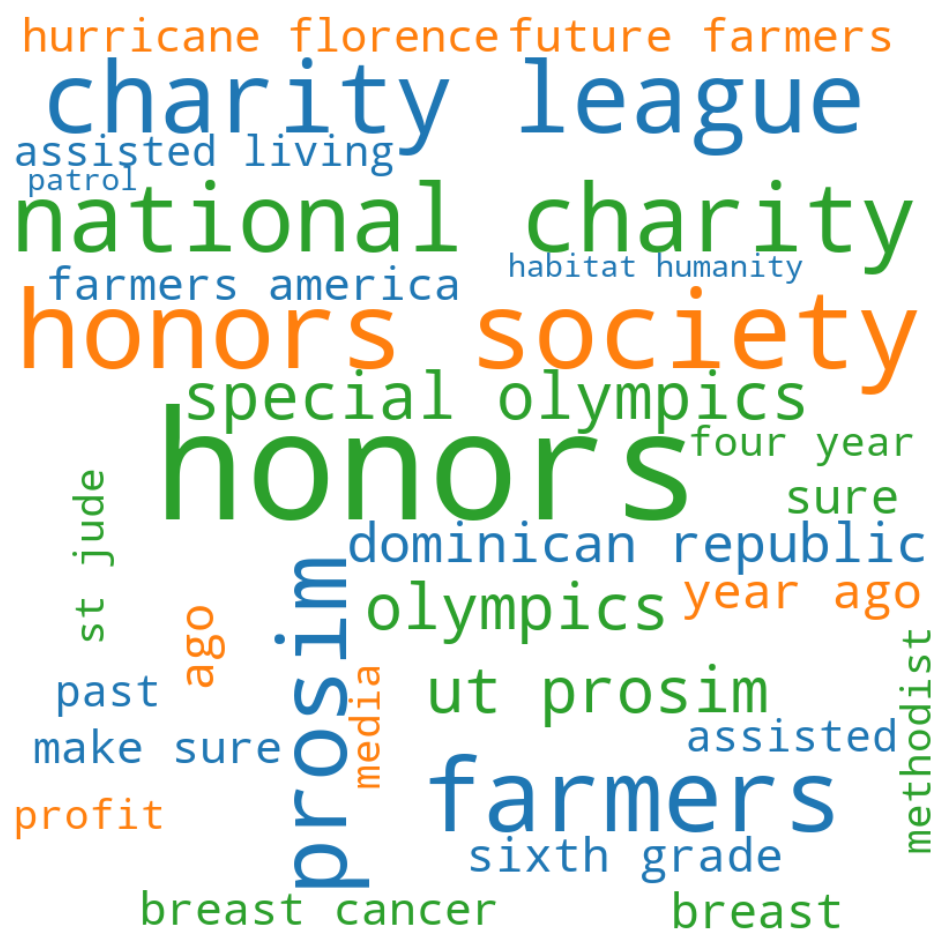

Word cloud saved to EQ1.png


In [38]:
# Top 30 scaled features
top_30_features_scaled = feature_importance_df_scaled_sorted.head(30)

# Define a blue-green-yellow color palette
color_palette = ["#1f77b4", "#2ca02c", "#ff7f0e"]  # Blue, Green, Yellow in hex

# Custom color function using the palette
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(color_palette)  # Randomly select a color from the palette

# Generate word cloud
wordcloud = WordCloud(
    color_func=color_func,
    background_color="white",
    max_words=30,  # Ensure only top words are included
    width=800,
    height=800,
    prefer_horizontal=0.8,  # Prefer horizontal words
    contour_color="black",  # Optional: outline the word cloud shape
    contour_width=1
).generate_from_frequencies(
    dict(zip(top_30_features_scaled['ngram'], top_30_features_scaled['abs_Class_0']))
)

# Plotting the word cloud
plt.figure(figsize=(12, 12))  # Balanced plot size
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

# Save the figure
output_path = "EQ1.png"  # Change file name if needed
plt.savefig(output_path, dpi=300, bbox_inches="tight", format="png")  # Save with high resolution
plt.show()

print(f"Word cloud saved to {output_path}")